In [314]:
BATCH_SIZE       = 128
GATE_OPTIMIZER   = 'sparsemax'   # 'softmax' | 'gumbel_softmax' | 'sparsemax'
NETWORK_LR       = 0.01
GUMBEL_TAU       = 0.5
GROUP_SUM_TAU    = 100
NETWORK_LAYERS   = 3
GATES            = 15_000
EPOCHS           = 2000
NOISE_TEMP = 0.1
RESIDUAL_LAYERS = 6
LOG_CSV          = "../logs/residual_cifar_run_logged.csv"           # append-only
from entmax import sparsemax

In [315]:
import csv
with open(LOG_CSV, mode='r') as file:
    csvFile = csv.DictReader(file)
    for row in csvFile:
        run_id = row['RUN_ID']
    run_id = int(run_id)

RUN_ID = run_id + 1


In [316]:
run_id

9

In [317]:

import os, csv, json, time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from difflogic import LogicLayer, GroupSum
from difflogic.packbitstensor import PackBitsTensor


In [318]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [319]:

# Note: The attached notebook uses CIFAR-10 with Normalize(0.5, 0.5, 0.5), keep the same to avoid deviating. 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

train_ds = datasets.CIFAR10(root='../data', train=True,  download=True, transform=transform)
test_ds  = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [320]:
def build_model(number_of_residual):
    layers = [nn.Flatten(),
              LogicLayer(3072, GATES, device='cuda', implementation='cuda',
                         gate_function=GATE_OPTIMIZER, 
                         gumbel_tau=GUMBEL_TAU, 
                         residual=RESIDUAL_LAYERS > 0)]
    for n in range(NETWORK_LAYERS - 1):
        if n < number_of_residual-1:
            layers.append(
            LogicLayer(GATES, GATES, device='cuda', implementation='cuda',
                       gate_function=GATE_OPTIMIZER, 
                       gumbel_tau=GUMBEL_TAU, 
                       residual=True)
        )
        else:
            layers.append(
                LogicLayer(GATES, GATES, device='cuda', implementation='cuda',
                        gate_function=GATE_OPTIMIZER, 
                        gumbel_tau=GUMBEL_TAU, 
                        residual=False)
            )
    layers.append(GroupSum(10, tau=GROUP_SUM_TAU))
    return nn.Sequential(*layers).to(device)

model = build_model(4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=NETWORK_LR)

In [321]:
@torch.no_grad()
def eval_accuracy_float(model, loader, mode='eval'):
    orig = model.training
    model.train(mode == 'train')
    total, correct = 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    model.train(orig)
    return correct / max(1, total)

def packbits_eval(model, loader):
    orig_mode = model.training
    start = time.perf_counter()
    with torch.no_grad():
        model.eval()
        res = np.mean([
            (
                model(
                    PackBitsTensor(
                        x.to('cuda').reshape(x.shape[0], -1).round().bool()
                    )
                ).argmax(-1) == y.to('cuda')
            ).to(torch.float32).mean().item()
            for x, y in loader
        ])
    model.train(mode=orig_mode)
    elapsed = time.perf_counter() - start
    throughput = len(loader.dataset) / elapsed
    print(f"throughput : {throughput:.1f}/s")
    return float(res)


In [322]:
# ==== Append-safe CSV header ====
fieldnames = [
    "epoch", "train_loss", "train_acc",
    "float_eval_acc", "float_trainmode_acc", "discrete_acc",
    "BATCH_SIZE", "GATE_OPTIMIZER", "NETWORK_LR", "GUMBEL_TAU",
    "GROUP_SUM_TAU", "NETWORK_LAYERS", "GATES", "EPOCHS", "RESIDUAL_LAYERS" , "NOISE_TEMP", "RUN_ID"
]
header_needed = (not os.path.exists(LOG_CSV)) or (os.path.getsize(LOG_CSV) == 0)
with open(LOG_CSV, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if header_needed:
        writer.writeheader()


In [323]:
@torch.no_grad()
def measure_discretization(model):
    discretization_scores = []
    for layer in model.modules():
        if isinstance(layer, LogicLayer):
            if layer.gate_function in ['sparsemax', 'sparsemax_noise']:
                w = sparsemax(layer.weights, dim=-1)
            else:
                w = torch.nn.functional.softmax(layer.weights, dim=-1)
            
            max_probs = w.max(dim=-1)[0].mean().item()
            discretization_scores.append(max_probs)
    
    return discretization_scores



In [324]:
def change_gate_optimizer(model, new_gate_optimizer,temp,gumbel_tau):
    for module in model.modules():
        if isinstance(module, LogicLayer):
            module.gate_function = new_gate_optimizer
            module.noise_temp = temp
            module.gumbel_tau = gumbel_tau


In [ ]:
GATE_OPTIMIZER = "sparsemax_noise"
NOISE_TEMP = 0.2
GUMBEL_TAU = 0.1
change_gate_optimizer(model, GATE_OPTIMIZER,NOISE_TEMP, GUMBEL_TAU) 


In [1]:
eval_acc_hist = []
disc_acc_hist = []


In [334]:
last_epoch = -1

In [335]:

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    seen = 0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        seen += x.size(0)

    train_loss = running_loss / max(1, seen)
    train_acc  = correct / max(1, seen)

    # Float eval vs train-mode
    float_eval_acc      = eval_accuracy_float(model, test_loader, mode='eval')
    float_trainmode_acc = eval_accuracy_float(model, test_loader, mode='train')

    discrete_acc = float_eval_acc
    last_epoch = epoch
    print(f"Epoch {epoch}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
          f"eval_test_acc={float_eval_acc:.4f} float_test_acc={float_trainmode_acc:.4f}")

    eval_acc_hist.append(float_eval_acc)
    disc_acc_hist.append(discrete_acc)

    # Append log row
    with open(LOG_CSV, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writerow(dict(
            epoch=epoch, train_loss=train_loss, train_acc=train_acc,
            float_eval_acc=float_eval_acc, float_trainmode_acc=float_trainmode_acc,
            discrete_acc=discrete_acc, 
            BATCH_SIZE=BATCH_SIZE, GATE_OPTIMIZER=GATE_OPTIMIZER, NETWORK_LR=NETWORK_LR,
            GUMBEL_TAU=GUMBEL_TAU, GROUP_SUM_TAU=GROUP_SUM_TAU,
            NETWORK_LAYERS=NETWORK_LAYERS, GATES=GATES, EPOCHS=EPOCHS, RUN_ID=RUN_ID, NOISE_TEMP = NOISE_TEMP, RESIDUAL_LAYERS = RESIDUAL_LAYERS
        ))


Epoch 1: train_loss=1.5258 train_acc=0.4842 eval_test_acc=0.4665 float_test_acc=0.4698
Epoch 2: train_loss=1.5072 train_acc=0.4925 eval_test_acc=0.4603 float_test_acc=0.4692
Epoch 3: train_loss=1.4981 train_acc=0.4961 eval_test_acc=0.4579 float_test_acc=0.4694
Epoch 4: train_loss=1.4922 train_acc=0.4989 eval_test_acc=0.4657 float_test_acc=0.4690
Epoch 5: train_loss=1.4869 train_acc=0.5005 eval_test_acc=0.4672 float_test_acc=0.4747
Epoch 6: train_loss=1.4835 train_acc=0.5043 eval_test_acc=0.4686 float_test_acc=0.4731
Epoch 7: train_loss=1.4804 train_acc=0.5042 eval_test_acc=0.4674 float_test_acc=0.4719
Epoch 8: train_loss=1.4780 train_acc=0.5050 eval_test_acc=0.4692 float_test_acc=0.4747
Epoch 9: train_loss=1.4759 train_acc=0.5049 eval_test_acc=0.4741 float_test_acc=0.4738
Epoch 10: train_loss=1.4736 train_acc=0.5066 eval_test_acc=0.4730 float_test_acc=0.4748
Epoch 11: train_loss=1.4731 train_acc=0.5073 eval_test_acc=0.4750 float_test_acc=0.4786
Epoch 12: train_loss=1.4710 train_acc=0.5

KeyboardInterrupt: 

22 epochs done

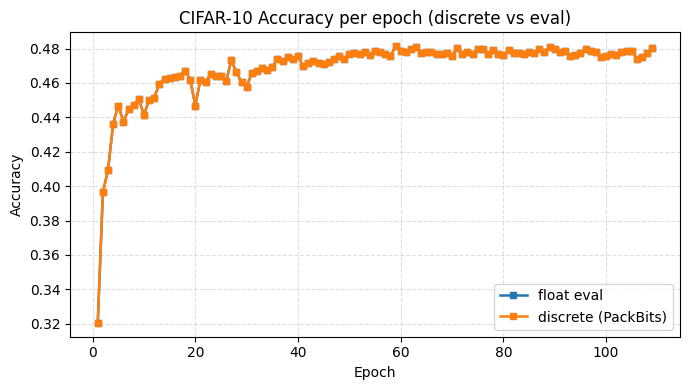

In [ ]:
# ==== Plot: discrete vs float-eval accuracy ====
plt.figure(figsize=(7, 4))
steps = np.arange(1, len(eval_acc_hist) + 1)
plt.plot(steps, eval_acc_hist, marker='s', linewidth=1.8, markersize=4, label='float eval')
plt.plot(steps, disc_acc_hist, marker='s', linewidth=1.8, markersize=4, label='discrete (PackBits)')
plt.title('CIFAR-10 Accuracy per epoch (discrete vs eval)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [337]:
torch.save(model,f'../checkpoints/new_models/{last_epoch}_epoch_{GATE_OPTIMIZER}_{GATES}_{NETWORK_LAYERS}l_id_{RUN_ID}.pth')